<a href="https://colab.research.google.com/github/Halakmaya/Classification-Medical-Images-Using-CNN/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.efficientnet import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle


In [ ]:
image_size = (224, 224)
train_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/train'
categories = ['benign', 'malignant', 'normal']

train_paths = []
train_labels = []

for label in categories:
    folder_path = os.path.join(train_dir, label)
    for image_file in os.listdir(folder_path):
        if image_file.endswith('.png'):
            train_paths.append(os.path.join(folder_path, image_file))
            train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels, random_state=42)


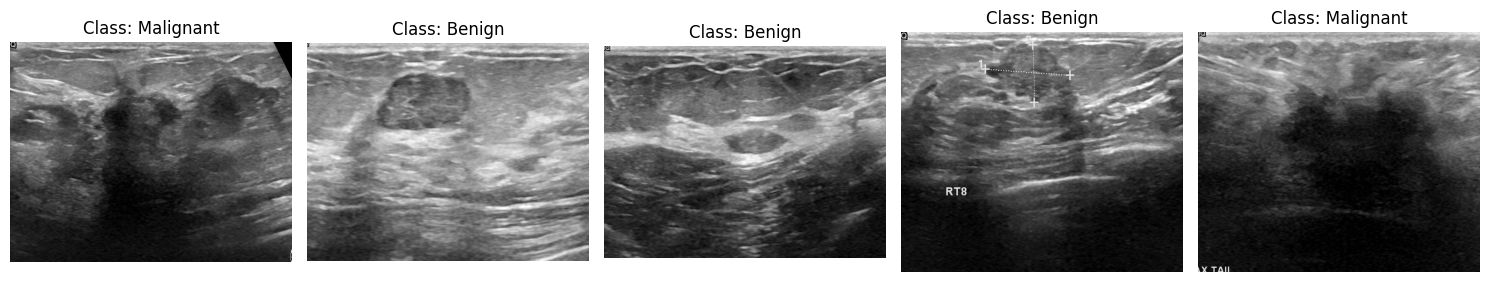

In [ ]:
def show_images_from_paths(paths, labels, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = random.randint(0, len(paths) - 1)
        img = Image.open(paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Class: {labels[idx].capitalize()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images_from_paths(train_paths, train_labels)


In [ ]:
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.15, random_state=42, stratify=train_labels
)


In [ ]:
def load_and_preprocess_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=image_size)
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.array(images)

X_train = load_and_preprocess_images(train_paths_split)
X_val = load_and_preprocess_images(val_paths)

label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}
y_train = np.array([label_dict[label] for label in train_labels_split])
y_val = np.array([label_dict[label] for label in val_labels])


In [ ]:
from PIL import ImageEnhance, ImageOps
from tqdm import tqdm

augmented_images = []
augmented_labels = []

for i in tqdm(range(len(train_paths_split))):
    img = Image.open(train_paths_split[i]).convert('RGB')
    label = train_labels_split[i]

    img = img.resize((224, 224))

    augmented_images.append(preprocess_input(np.array(img)))
    augmented_labels.append(label_dict[label])

    enhancer = ImageEnhance.Brightness(img)
    bright_img = enhancer.enhance(1.5)
    augmented_images.append(preprocess_input(np.array(bright_img)))
    augmented_labels.append(label_dict[label])

    enhancer = ImageEnhance.Contrast(img)
    contrast_img = enhancer.enhance(1.3)
    augmented_images.append(preprocess_input(np.array(contrast_img)))
    augmented_labels.append(label_dict[label])

    rotated_img = img.rotate(20)
    augmented_images.append(preprocess_input(np.array(rotated_img)))
    augmented_labels.append(label_dict[label])

    flipped_img = ImageOps.mirror(img)
    augmented_images.append(preprocess_input(np.array(flipped_img)))
    augmented_labels.append(label_dict[label])

X_train_augmented = np.array(augmented_images)
y_train_augmented = np.array(augmented_labels)


100%|██████████| 562/562 [00:12<00:00, 46.53it/s]


In [ ]:
val_images = []
for path in tqdm(val_paths):
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    val_images.append(img_array)

X_val = np.array(val_images)
y_val = np.array([label_dict[label] for label in val_labels])


100%|██████████| 100/100 [00:01<00:00, 59.55it/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_augmented),
    y=y_train_augmented
)

class_weights_dict = dict(enumerate(class_weights))


In [ ]:


from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Initialize VGG16 model for transfer learning
base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a few more layers on top for your specific task
model = Sequential()
model.add(base_model)
model.add(Flatten())  # Flatten the output o
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001,  weight_decay=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])


In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def step_decay(epoch, lr):
    drop = 0.5  # Factor to drop the learning rate by
    epochs_drop = 5  # Number of epochs after which to drop the learning rate
    if epoch % epochs_drop == 0 and epoch != 0:
        return lr * drop
    return lr

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)


In [ ]:
batch_size = 32
epochs = 20
steps_per_epoch = int(len(X_train_augmented) / batch_size)

history = model.fit(
    X_train_augmented, y_train_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler],
    class_weight=class_weights_dict
)



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1627s 18s/step - loss: 3.8603 - sparse_categorical_accuracy: 0.5203 - val_loss: 0.8312 - val_sparse_categorical_accuracy: 0.7300 - learning_rate: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1642s 18s/step - loss: 0.5679 - sparse_categorical_accuracy: 0.7953 - val_loss: 0.6423 - val_sparse_categorical_accuracy: 0.7700 - learning_rate: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1677s 19s/step - loss: 0.3332 - sparse_categorical_accuracy: 0.8648 - val_loss: 0.6510 - val_sparse_categorical_accuracy: 0.7900 - learning_rate: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 1666s 18s/step - loss: 0.2429 - sparse_categorical_accura

In [ ]:
model.save("/content/drive/MyDrive/vgg_10s_v1.h5")
print("✅ Model saved to Google Drive!")

✅ Model saved to Google Drive!


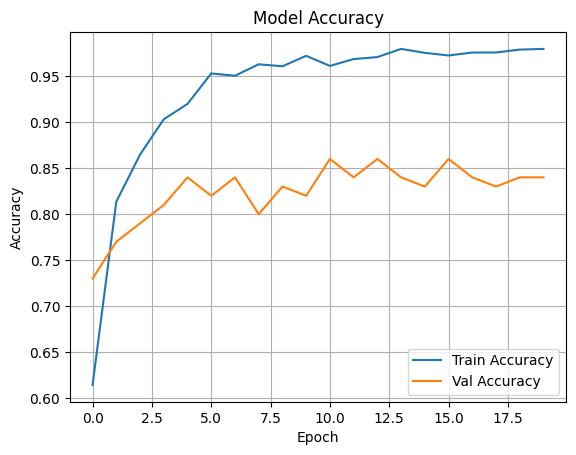

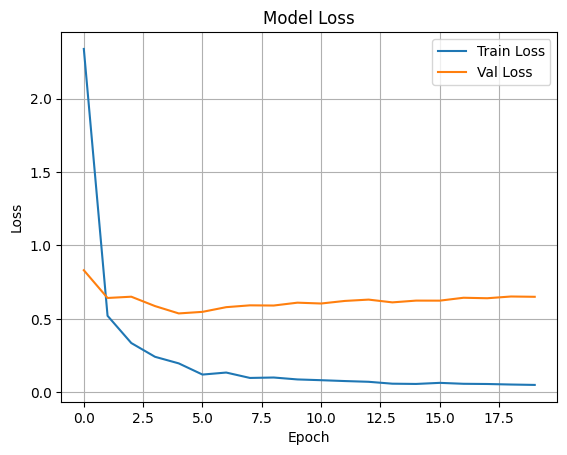

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import os
from PIL import Image
import numpy as np

test_dir = '/content/drive/MyDrive/Dataset_BUSI_Split/test'
categories = ['benign', 'malignant', 'normal']
label_dict = {'benign': 0, 'malignant': 1, 'normal': 2}

test_paths = []
test_labels = []

for label in categories:
    for filename in os.listdir(os.path.join(test_dir, label)):
        if filename.endswith('.png'):
            test_paths.append(os.path.join(test_dir, label, filename))
            test_labels.append(label_dict[label])

# Load and preprocess test images
X_test = []
for path in test_paths:
    img = Image.open(path).convert('RGB')
    img = img.resize((224, 224))
    img_array = np.array(img)
    img_array = preprocess_input(img_array)
    X_test.append(img_array)

X_test = np.array(X_test)
y_test = np.array(test_labels)


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 64s 15s/step - loss: 0.6004 - sparse_categorical_accuracy: 0.7702
✅ Test Accuracy: 0.7797


4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 16s/step


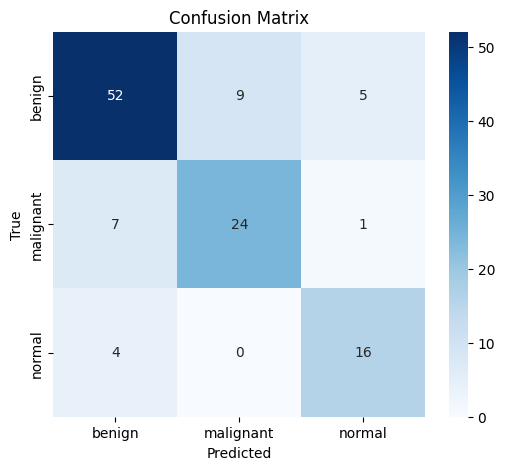

Classification Report:

              precision    recall  f1-score   support

      benign       0.83      0.79      0.81        66
   malignant       0.73      0.75      0.74        32
      normal       0.73      0.80      0.76        20

    accuracy                           0.78       118
   macro avg       0.76      0.78      0.77       118
weighted avg       0.78      0.78      0.78       118



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_labels, target_names=categories))


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/vgg_10s_v1.h5')
# Binarize the true labels
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # One-hot encoding for multiclass
y_pred_bin = model.predict(X_test)

# Calculate ROC for each class
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_pred_bin[:, 0])
roc_auc = auc(fpr, tpr)

fpr1, tpr1, _ = roc_curve(y_test_bin[:, 1], y_pred_bin[:, 1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test_bin[:, 2], y_pred_bin[:, 2])
roc_auc2 = auc(fpr2, tpr2)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr, tpr, color='blue', lw=2, label=f'Benign (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'Malignant (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='red', lw=2, label=f'Normal (AUC = {roc_auc2:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()
